In [31]:
import igraph as ig
import pandas as pd
import numpy as np

In [32]:
comments_df = pd.read_csv('../reddit_comments.csv')

In [33]:
post_id_color = {}
post_id_title = {}
np.random.seed(0)
color_list = ['yellow', 'green', 'blue', 'red', 'purple', 'orange', 'pink', 'brown']
i = 0
for post_id in comments_df['post_id'].unique():
    post_id_color[post_id] = color_list[i]
    post_id_title[post_id] = comments_df[comments_df['post_id'] == post_id].iloc[0]['post_title'][0:20]
    i += 1
print(post_id_color)
print(post_id_title)

{'17z2hci': 'yellow', '1bulhj9': 'green', '1b6cg4q': 'blue', '17lese9': 'red', '1cwqkqe': 'purple', '10v8sey': 'orange', '197vo6o': 'pink', '1d5h5h6': 'brown'}
{'17z2hci': 'Ho visto troppi post', '1bulhj9': 'Il problema del cald', '1b6cg4q': 'Possibile guerra NAT', '17lese9': '4000 bambini morti i', '1cwqkqe': 'Chi voterete alle eu', '10v8sey': 'Natura sì: niente ci', '197vo6o': 'Altre nubi sui Ferra', '1d5h5h6': 'Boom di giovani in f'}


In [34]:
# Creiamo il grafo originale con tutti i nodi e archi
g = ig.Graph(directed=True)
g.add_vertex(name=comments_df.iloc[0]['comment_parent_id'], color='black', label = comments_df.iloc[0]['comment_parent_name'], post_id=comments_df.iloc[0]['post_id'])

for comment in comments_df.iloc[1:].iterrows():
    author_id = comment[1]['comment_author_id']
    author_name = comment[1]['comment_author_name']
    parent_id = comment[1]['comment_parent_id']
    comment_id = comment[1]['comment_id']
    post_id = comment[1]['post_id']
    comment_score = int(comment[1]['comment_score'])
    color = post_id_color[post_id]
    
    if author_id not in g.vs['name']:
        if parent_id in g.vs['name']:
            g.add_vertex(name=author_id, color=color, post_id=post_id, label=author_name)
            g.add_edge(author_id, parent_id, weight=comment_score, comment_id = comment_id)
    else:
        if parent_id in g.vs['name'] and parent_id != author_id:
            g.add_edge(author_id, parent_id, weight=comment_score,  comment_id = comment_id)

g.delete_vertices(['0','deleted'])

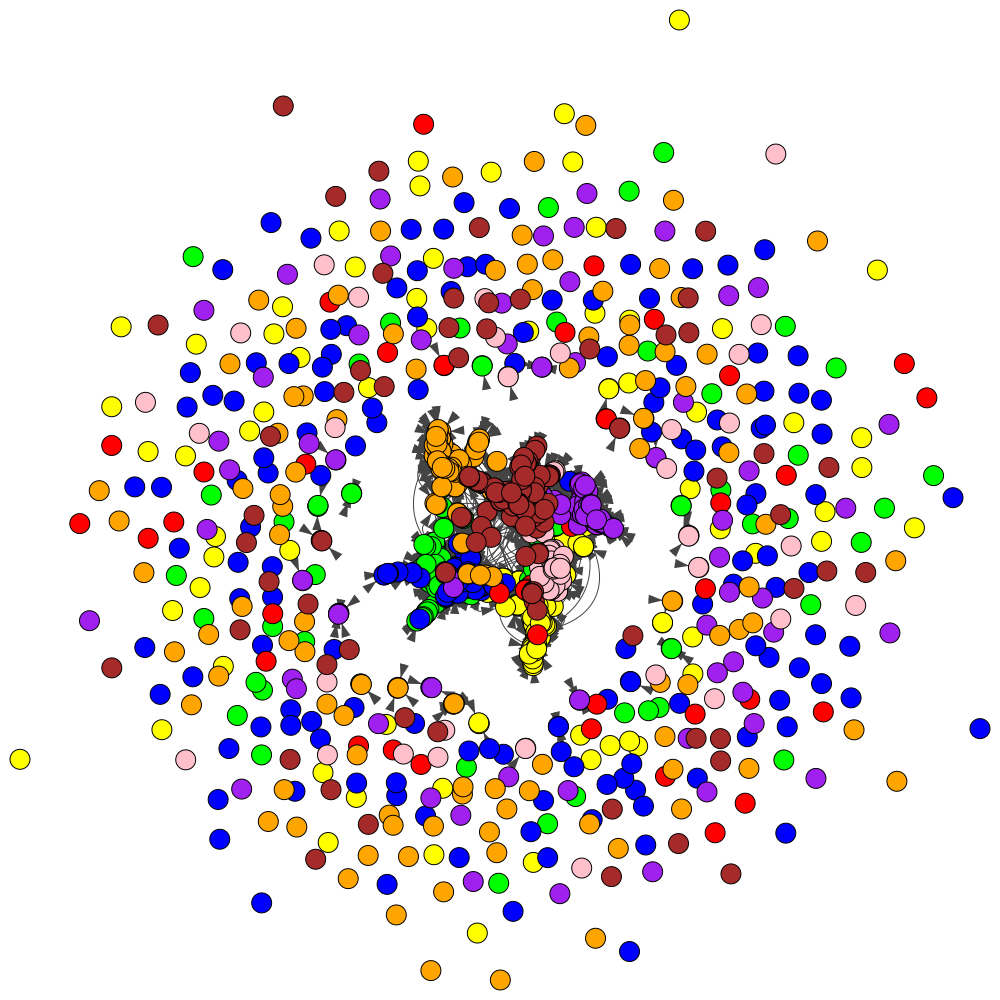

In [35]:
visual_style = {
    "vertex_label": None,
    "bbox": (1000, 1000)
}

ig.plot(g, **visual_style)

### Pulizia dei grafi

In [46]:
post_graphs = {}
for post_id in set(g.vs['post_id']):
    post_vertices = [v.index for v in g.vs if v['post_id'] == post_id]
    subgraph = g.subgraph(post_vertices)    
    post_graphs[post_id] = subgraph
    deleted_vertices = []
    for v in subgraph.vs:
        if v.neighbors() == []:
            deleted_vertices.append(v)

    subgraph.delete_vertices(deleted_vertices)

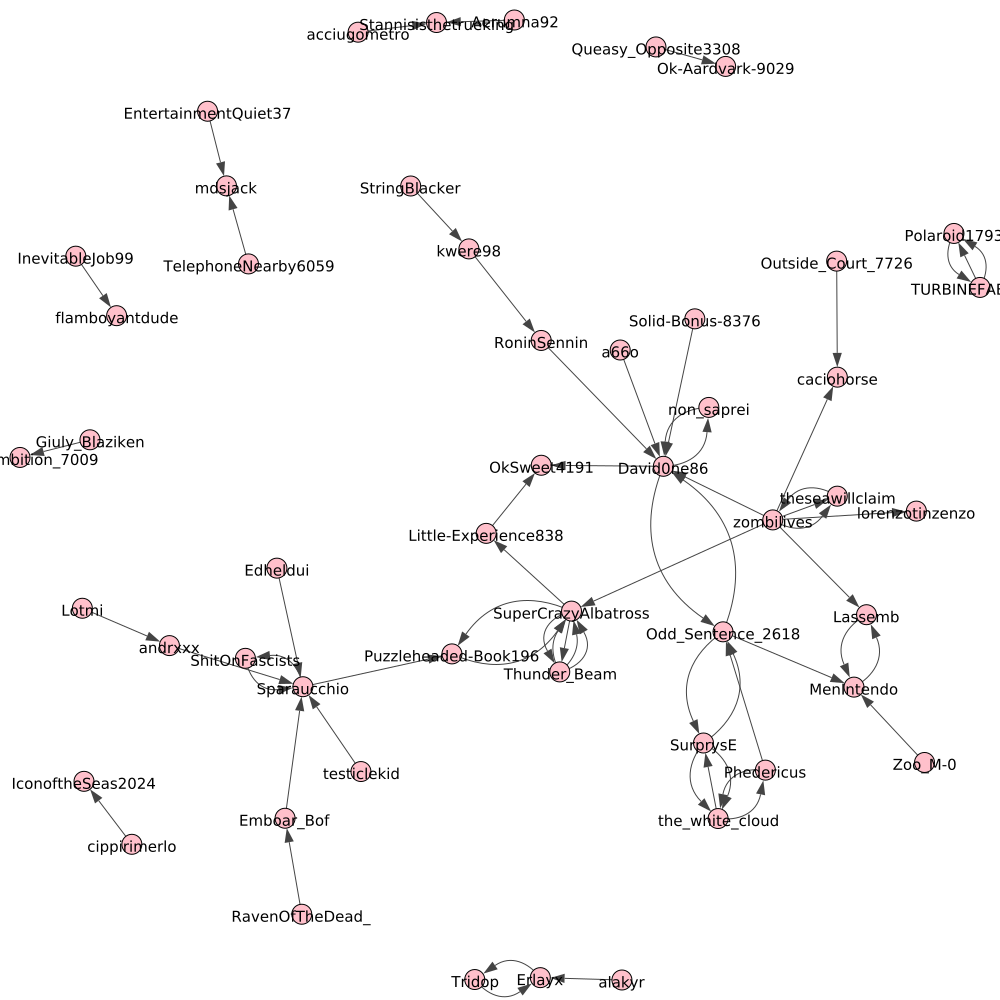

In [50]:
visual_style = {
    "bbox": (1000, 1000),
    "vertex_label_size": 15
}

graph = post_graphs.popitem()[1]
ig.plot(graph, **visual_style)

# Ricerca delle discussioni
Utilizzo la definizione per induzione di discussione per trovare le discussioni all'interno di un singolo post

### Caso base

In [51]:
def find_minimal_debate(graph):
    color_list = ['yellow', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'black','lightblue','lightgreen','lime','magenta','maroon','navy','olive','purple','silver','teal','white','yellow']
    i = 0
    for vertex in graph.vs:
        a = vertex['label']
        b = vertex['color']
        if vertex['color'] == 'red' and vertex['debate_id'] == 0:
            color = color_list[i % len(color_list)]
            i += 1
            neighbors = vertex.neighbors()
            if neighbors != []:
                for vertex_neighbor in neighbors:
                    a = vertex_neighbor['label']
                    b = vertex_neighbor['color']
                    if vertex_neighbor['color'] == 'red' and vertex_neighbor['debate_id'] == 0:
                        try:
                            vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=vertex_neighbor.index)
                        except:
                            vertex_to_neighbor = None
                        try:
                            neighbors_to_vertex = graph.es.find(_source=vertex_neighbor.index, _target=vertex.index)
                        except:
                            neighbors_to_vertex = None
                        if vertex_to_neighbor and neighbors_to_vertex:
                            vertex['color'] = color
                            vertex['debate_id'] = i
                            vertex_neighbor['color'] = color
                            vertex_neighbor['debate_id'] = i
                            break

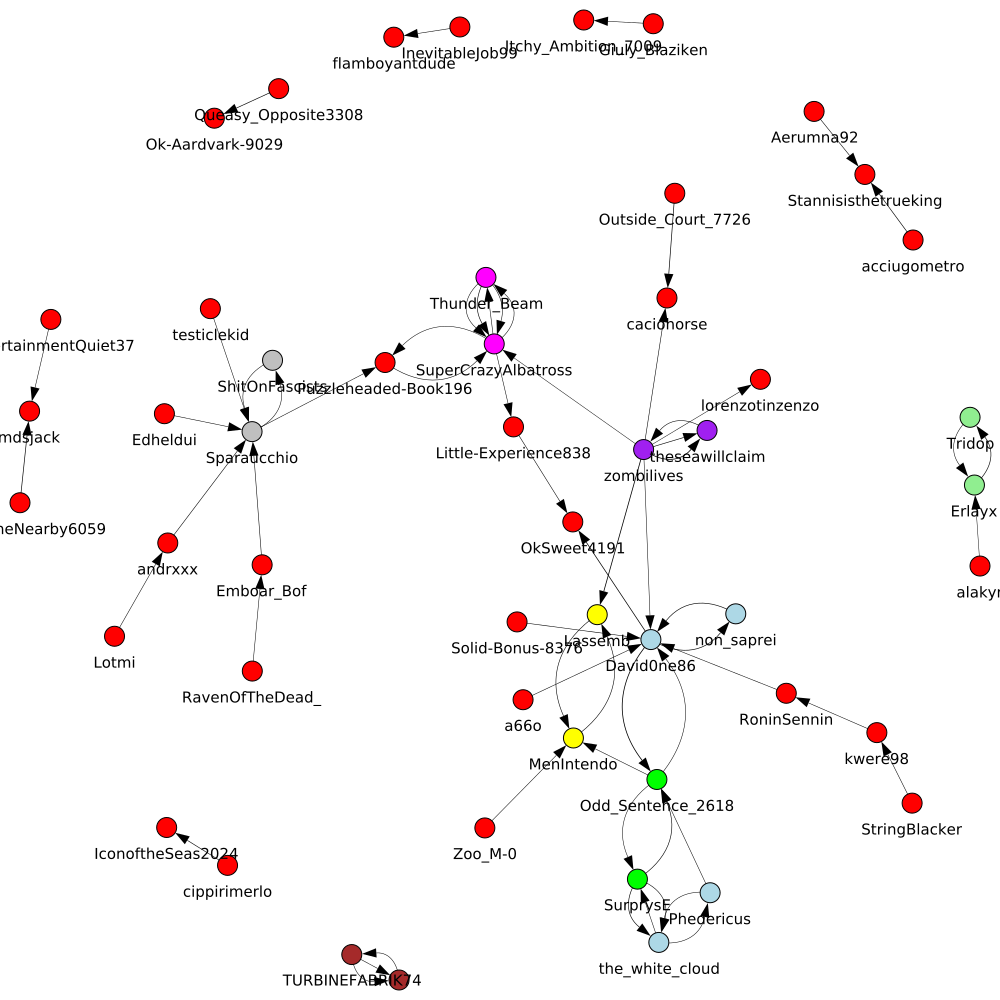

In [52]:
visual_style = {
    "vertex_size": 20,  # Aumenta la dimensione dei nodi a 50
    "vertex_label_size": 15,  # Aumenta la dimensione delle etichette dei nodi a 15
    "edge_color": "black",  # Colore degli archi nero
    #"edge_arrow_size": 3,  # Aumenta la dimensione delle frecce degli archi a 2
    "edge_width": [0.5 + 2 * weight / max(g.es['weight']) for weight in g.es['weight']],  # Spessore degli archi basato sul peso
    "vertex_label_dist": 2,  # Imposta la distanza delle etichette dei nodi a 2
    "bbox": (1000, 1000),  # Dimensione dell'area di disegno (1200x1200 pixel)
}
cb_graph = graph.copy()
cb_graph.vs['debate_id'] = 0
cb_graph.vs['color'] = 'red'
find_minimal_debate(cb_graph)
ig.plot(cb_graph, **visual_style)

### Passo Ricorsivo

In [54]:
def find_complete_discussion(vertex, graph):
    color = vertex['color']
    debate_id = vertex['debate_id']
    neighbors = vertex.neighbors()
    for neighbor in neighbors:
        if neighbor['color'] != color and neighbor['debate_id'] != debate_id:
            try:
                vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=neighbor.index)
            except:
                vertex_to_neighbor = None
            
            try:
                neighbors_to_vertex = graph.es.find(_source=neighbor.index, _target=vertex.index)
            except:
                neighbors_to_vertex = None

            if neighbors_to_vertex or (vertex_to_neighbor and neighbors_to_vertex):

                neighbor['color'] = color
                neighbor['debate_id'] = debate_id
                find_complete_discussion(neighbor, graph)

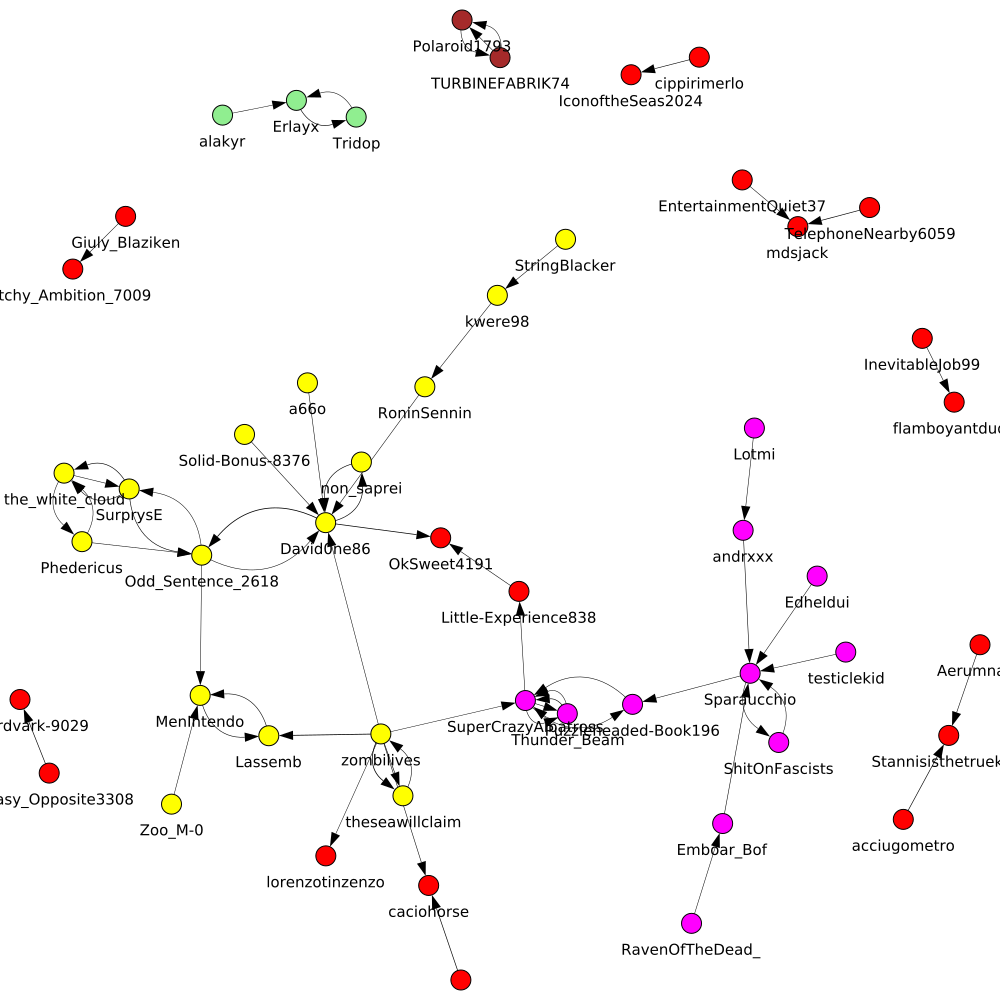

In [58]:
for vertex in cb_graph.vs:
    if vertex['color'] != 'red':
        find_complete_discussion(vertex, cb_graph)

ig.plot(cb_graph, **visual_style)

In [56]:
for v in cb_graph.vs:
    print(v['debate_id'])

0
21
0
21
0
0
7
0
21
21
10
0
12
0
21
0
0
0
0
21
12
0
0
21
0
0
21
10
10
0
21
0
21
21
12
0
21
21
12
0
21
21
21
7
12
12
12
12
12
12
12


In [59]:
import csv

fieldnames = [
    'comment_id',
    'commentatore',
    'commentato',
    'testo'
]



# Open the file in append mode
with open('../debate.csv', 'w+', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()

    for edge in cb_graph.es:
        source = cb_graph.vs[edge.source]
        target = cb_graph.vs[edge.target]

        if source['debate_id'] == target['debate_id'] and source['debate_id'] == 12:

            writer.writerow({
                'comment_id': edge['comment_id'],
                'commentatore': source['label'],
                'commentato': target['label'],
                'testo': comments_df[comments_df['comment_id'] == edge['comment_id']].iloc[0]['comment_body']
            })